In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from astropy.io import fits
from unyt import um

from synference import SBI_Fitter
from synference.utils import transform_spectrum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import torch
from torch import nn
from torch.nn import functional as F

class LogCoshLoss(nn.Module):
    """
    Log-Cosh Loss Function.
    This loss is smoother than L2 loss and less sensitive to outliers.
    It is twice differentiable everywhere, unlike Huber loss.
    """
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        # The `torch.log(torch.cosh(x))` is numerically stable enough for typical network outputs.
        diff = y_pred - y_true
        return torch.log(torch.cosh(diff)).sum()

class SpenderLikeVAE(nn.Module):
    """
    A VAE with encoder architecture matching SPENDER.

    The encoder consists of:
    1. A 3-layer 1D CNN with increasing kernel sizes, instance normalization, 
       PReLU activation, dropout, and max pooling.
    2. A dot-product attention mechanism over the wavelength dimension.
    3. A 3-layer MLP to produce the parameters of the latent distribution.

    The decoder is a simple 3-layer MLP that reconstructs the spectrum from a
    latent sample.
    """
    def __init__(self, input_dim=1001, latent_dim=16, dropout=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # --- ENCODER (SPENDER-style) ---
        # 1. Convolutional Frontend with normalization and dropout
        filters = [128, 256, 512]
        sizes = [5, 11, 21]
        
        # Build conv blocks matching SPENDER
        self.conv_blocks = nn.ModuleList()
        for i in range(len(filters)):
            f_in = 1 if i == 0 else filters[i - 1]
            f_out = filters[i]
            kernel_size = sizes[i]
            padding = kernel_size // 2
            
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=f_in, out_channels=f_out, 
                         kernel_size=kernel_size, padding=padding),
                nn.InstanceNorm1d(f_out),
                nn.PReLU(f_out),
                nn.Dropout(p=dropout)
            )
            self.conv_blocks.append(conv_block)
        
        # Pooling layers (match SPENDER)
        self.pool1 = nn.MaxPool1d(sizes[0], padding=sizes[0] // 2)
        self.pool2 = nn.MaxPool1d(sizes[1], padding=sizes[1] // 2)
        
        # Calculate the length after pooling
        conv_output_len = input_dim
        # After pool1
        conv_output_len = (conv_output_len + 2 * (sizes[0] // 2)) // sizes[0]
        # After pool2
        conv_output_len = (conv_output_len + 2 * (sizes[1] // 2)) // sizes[1]
        
        # 2. Attention Module
        # Split channels into h and k for attention
        self.n_feature = filters[-1] // 2
        
        # 3. MLP for latent space parameters (match SPENDER structure)
        n_hidden = [128, 64, 32]
        
        self.enc_fc1 = nn.Linear(self.n_feature, n_hidden[0])
        self.enc_act1 = nn.PReLU(n_hidden[0])
        self.enc_drop1 = nn.Dropout(p=dropout)
        
        self.enc_fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.enc_act2 = nn.PReLU(n_hidden[1])
        self.enc_drop2 = nn.Dropout(p=dropout)
        
        self.enc_fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.enc_act3 = nn.PReLU(n_hidden[2])
        self.enc_drop3 = nn.Dropout(p=dropout)
        
        # Output layers for mu and log_var
        self.enc_fc_mu = nn.Linear(n_hidden[2], latent_dim)
        self.enc_fc_log_var = nn.Linear(n_hidden[2], latent_dim)

        # --- DECODER ---
        # A simple 3-layer MLP as described in the spender paper
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, 256)
        self.dec_fc3 = nn.Linear(256, input_dim)

        # Decoder activation
        self.act_fn = nn.SiLU()

    def attention(self, x):
        """
        Dot-product attention mechanism as described in the SPENDER paper.
        Splits channels into two halves (h and k), computes softmax attention
        weights from k, and applies them to h.
        """
        # x shape: (batch, channels, length)
        # Split channels into two halves
        h = x[:, :self.n_feature, :]
        k = x[:, self.n_feature:, :]

        # Softmax operates on the wavelength dimension (last dimension)
        softmax_k = F.softmax(k, dim=-1)

        # Element-wise product
        e = h * softmax_k
        
        # Sum across wavelength dimension (like SPENDER)
        e = torch.sum(e, dim=2)
        
        return e

    def encode(self, x):
        """
        Encode input spectrum to latent distribution parameters.
        
        Parameters
        ----------
        x : torch.Tensor, shape (batch, input_dim)
            Input spectra
            
        Returns
        -------
        mu : torch.Tensor, shape (batch, latent_dim)
            Mean of latent distribution
        log_var : torch.Tensor, shape (batch, latent_dim)
            Log variance of latent distribution
        """
        # Reshape input for Conv1d: (batch, channels, length)
        x = x.unsqueeze(1)

        # CNN frontend with pooling (SPENDER-style)
        x = self.pool1(self.conv_blocks[0](x))
        x = self.pool2(self.conv_blocks[1](x))
        x = self.conv_blocks[2](x)

        # Attention (reduces wavelength dimension)
        x = self.attention(x)

        # MLP with PReLU activations and dropout
        x = self.enc_drop1(self.enc_act1(self.enc_fc1(x)))
        x = self.enc_drop2(self.enc_act2(self.enc_fc2(x)))
        x = self.enc_drop3(self.enc_act3(self.enc_fc3(x)))
        
        # Output mu and log_var
        mu = self.enc_fc_mu(x)
        log_var = self.enc_fc_log_var(x)
        
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick for VAE.
        
        Parameters
        ----------
        mu : torch.Tensor
            Mean of latent distribution
        log_var : torch.Tensor
            Log variance of latent distribution
            
        Returns
        -------
        z : torch.Tensor
            Sampled latent vector
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decode latent vector to reconstructed spectrum.
        
        Parameters
        ----------
        z : torch.Tensor, shape (batch, latent_dim)
            Latent vectors
            
        Returns
        -------
        reconstructed_x : torch.Tensor, shape (batch, input_dim)
            Reconstructed spectra
        """
        x = self.act_fn(self.dec_fc1(z))
        x = self.act_fn(self.dec_fc2(x))
        # No final activation to allow for arbitrary flux values
        reconstructed_x = self.dec_fc3(x)
        return reconstructed_x

    def forward(self, x):
        """
        Forward pass through the VAE.
        
        Parameters
        ----------
        x : torch.Tensor, shape (batch, input_dim)
            Input spectra
            
        Returns
        -------
        reconstructed_x : torch.Tensor, shape (batch, input_dim)
            Reconstructed spectra
        mu : torch.Tensor, shape (batch, latent_dim)
            Mean of latent distribution
        log_var : torch.Tensor, shape (batch, latent_dim)
            Log variance of latent distribution
        """
        mu, log_var = self.encode(x)
        return mu
    
    def forward_vae(self, x):
        """
        Full VAE forward pass for training (regardless of embedding_mode).
        
        Parameters
        ----------
        x : torch.Tensor, shape (batch, input_dim)
            Input spectra
            
        Returns
        -------
        reconstructed_x : torch.Tensor, shape (batch, input_dim)
            Reconstructed spectra
        mu : torch.Tensor, shape (batch, latent_dim)
            Mean of latent distribution
        log_var : torch.Tensor, shape (batch, latent_dim)
            Log variance of latent distribution
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    @property
    def n_parameters(self):
        """Number of trainable parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def vae_loss(recons_x, x, mu, log_var):
    """
    Calculates the VAE loss using the specified LogCoshLoss for reconstruction.
    
    Parameters
    ----------
    recons_x : torch.Tensor
        Reconstructed spectra
    x : torch.Tensor
        Original spectra
    mu : torch.Tensor
        Mean of latent distribution
    log_var : torch.Tensor
        Log variance of latent distribution
        
    Returns
    -------
    loss : torch.Tensor
        Total VAE loss (reconstruction + KL divergence)
    """
    log_cosh_loss = LogCoshLoss()
    recon_loss = log_cosh_loss(recons_x, x)

    # KL Divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kld_loss



In [13]:
fitter = SBI_Fitter.init_from_hdf5(
    "Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode",
    "/cosma7/data/dp276/dc-harv3/work/sbi_grids/grid_spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode.hdf5",  # noqa: E501
)

In [ ]:
tab = fits.getdata("/cosma/apps/dp276/dc-harv3/synference/priv/jwst_nirspec_prism_disp.fits")
wavs = tab["WAVELENGTH"] * um
R = tab["R"]

In [7]:
fitter.create_feature_array(
    flux_units="log10 nJy",
    crop_wavelength_range=(0.6, 5.0),
    resample_wavelengths=wavs,
    inst_resolution_wavelengths=wavs,
    inst_resolution_r=R,
    theory_r=np.inf,
    min_flux_value=-10,
)

2025-11-08 20:09:46,093 | synference | INFO     | Redshift detected. Transforming spectra to observed frame.


Transforming spectra: 100%|██████████| 25000/25000 [08:43<00:00, 47.77it/s]


2025-11-08 20:18:29,776 | synference | INFO     | Spectra feature array created with shape (25000, 1001).
2025-11-08 20:18:29,778 | synference | INFO     | Wavelength Range: 0.500 - 6.000 um
2025-11-08 20:18:29,799 | synference | INFO     | Min flux: -10.000 log10 nJy
2025-11-08 20:18:29,821 | synference | INFO     | Max flux: 11.172 log10 nJy
2025-11-08 20:18:29,881 | synference | INFO     | Fraction of NaN/INF values in feature array: 0.000%


In [47]:
run_model = SBI_Fitter.load_saved_model(
    "/cosma/apps/dp276/dc-harv3/synference/models/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode" # noqa: E501
)

2025-11-09 15:03:44,349 | synference | INFO     | Loaded model from /cosma/apps/dp276/dc-harv3/synference/models/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode_spender_vae_latent64_posterior.pkl.
2025-11-09 15:03:44,351 | synference | INFO     | Device: cpu


Redshift: 6.33, log10(M/Msun): 10.66


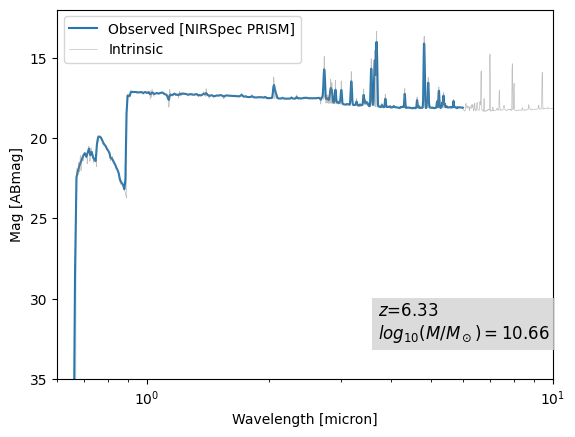

In [275]:
idx = 52

import matplotlib.pyplot as plt
import numpy as np

redshift = run_model.fitted_parameter_array[idx][0]
mass = run_model.fitted_parameter_array[idx][1]
plt.plot(
    wavs,
    -2.5 * np.log10((1 + redshift) * 10 ** run_model.feature_array[idx]) + 31.4,
    label="Observed [NIRSpec PRISM]",
)
plt.gca().invert_yaxis()

print(f"Redshift: {redshift:.2f}, log10(M/Msun): {mass:.2f}")
plt.text(
    3.7,
    32.5,
    f"$z$={redshift:.2f}\n$log_{{10}}(M/M_\\odot)={mass:.2f}$",
    fontsize=12,
    color="black",
    bbox=dict(facecolor="lightgrey", alpha=0.8, edgecolor="none"),
)
# Show Lyman break
"""plt.axvline(0.1216 * (1 + redshift), color='k', linestyle='--', label='Lyman break')
plt.axvline(0.0912 * (1 + redshift), color='k', linestyle=':', label='Lyman limit')
# Show Hb, Ha
plt.axvline(0.4861 * (1 + redshift), color='r', linestyle='--', label='Hβ')
plt.axvline(0.6563 * (1 + redshift), color='r', linestyle=':', label='Hα')
# Show OIII, OII
plt.axvline(0.5007 * (1 + redshift), color='g', linestyle='--', label='[OIII]')
plt.axvline(0.3727 * (1 + redshift), color='g', linestyle=':', label='[OII]')"""

# normal_spec
ax = plt.gca()
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())
orig = -2.5 * np.log10(run_model.raw_observation_grid[:, idx]*(1 + redshift)) + 31.4
plt.plot(
    run_model.raw_observation_names*(1 + redshift),
    orig,
    color="gray",
    alpha=0.5,
    linewidth=0.5,
    label="Intrinsic",
)
plt.xlabel("Wavelength [micron]")
plt.ylabel("Mag [ABmag]")
plt.legend()
plt.ylim(35, None)
plt.xlim(0.6, 10)
plt.xscale("log")

In [49]:
run_model.recreate_simulator_from_grid();

params: {'tau_v': 'tau_v', 'fesc_ly_alpha': 0.0, 'dust_curve': <synthesizer.emission_models.transformers.dust_attenuation.Calzetti2000 object at 0x1488b0dc0ad0>, 'dust_emission': <synthesizer.emission_models.dust.emission.Greybody object at 0x1488a10087a0>}
illegal target for annotation (<string>, line 1)
2025-11-09 15:04:38,158 | synference | ERROR    | Error evaluating transform function for tau_v: illegal target for annotation (<string>, line 1)
2025-11-09 15:04:38,162 | synference | INFO     | Simulator recreated from grid at /cosma7/data/dp276/dc-harv3/work/sbi_grids/grid_spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode.hdf5.
2025-11-09 15:04:38,163 | synference | INFO     | Adding Av to tau_v transform.


## Setup required parameter transforms for this simulator


In [ ]:
from astropy.cosmology import Planck18
from unyt import unyt_array, Myr

def continuity_agebins(
    redshift,
    cosmo=Planck18,
    Nbins=6,
    first_bin=3 * Myr,
    second_bin=10 * Myr,
    last_bin="15%",
    max_redshift=20,
):
    """
    Generate age bins for the Continuity SFH.
    The first two bins are fixed, the last bin is a percentage of the maximum age at that redshift,
    and the middle bins are logarithmically spaced.

    Parameters
    ----------
    redshift : float
        The redshift at which to calculate the age bins.
    cosmo : astropy.cosmology.Cosmology, optional
        The cosmology to use for age calculations, by default Planck18.
    Nbins : int, optional
        The total number of bins, by default 6.
    first_bin : unyt_quantity, optional
        The ending lookback time for the first bin, by default 3 Myr.
    second_bin : unyt_quantity, optional
        The ending lookback time for the second bin, by default 10 Myr.
    last_bin : str or unyt_quantity, optional
        The ending lookback time for the last bin, which can be a percentage of the max_age
        at that redshift or a fixed value, by default '15%'.
    max_redshift : float, optional
        The maximum redshift to consider for the age bins, by default 20.
    Returns
    -------
    list of unyt_quantity
        The age bins in lookback time.

    """

    if isinstance(redshift, dict):
        redshift = redshift["redshift"]

    # Calculate the maximum age at the given redshift
    max_age = cosmo.age(redshift).to_value("Myr")
    age_at_max = cosmo.age(max_redshift).to_value("Myr")
    available_age = max_age - age_at_max

    bins = [0.0, first_bin.to_value("Myr")]
    if isinstance(last_bin, str) and last_bin.endswith("%"):
        # If last_bin is a percentage, calculate it based on the remaining age
        last_bin_value = available_age * float(last_bin[:-1]) / 100.0
    else:
        # Otherwise, treat last_bin as a fixed value
        last_bin_value = last_bin.to_value("Myr")

    age_at_last_bin = available_age - last_bin_value
    # Generate the middle bins logarithmically spaced
    middle_bins = np.logspace(
        np.log10(second_bin),
        np.log10(age_at_last_bin),
        Nbins - 2,
    )
    # Combine all bins and convert to unyt_quantity
    all_bins = np.concatenate((bins, middle_bins, [available_age]))

    # reshape to (N, 2) and readd relevant bins to mathc shape.
    # e.g. (0, 1e7), (1e7, 1e8), (1e8, 1.5e8), (1.5e8, 2.0e8), (2.0e8, 3.0e8), (3.0e8, 4.0e8)
    all_bins = np.array([(all_bins[i], all_bins[i + 1]) for i in range(len(all_bins) - 1)])
    all_bins = unyt_array(all_bins, "Myr")

    return all_bins


k  = tuple([f"logsfr_ratio_{j}" for j in range(5)])

def create_cont(**kwargs):
    return np.array([kwargs[f"logsfr_ratio_{j}"] for j in range(len(kwargs))])


run_model.simulator.param_transforms["agebins"] = continuity_agebins
run_model.simulator.param_transforms[k] = ('logsfr_ratios', create_cont)


run_model.simulator.param_transforms["Av"] = ("tau_v", lambda Av: Av / 1.086)
run_model.simulator.output_type = ["fnu", "photo_fnu"]
run_model.simulator.out_flux_unit = "nJy"

In [276]:
samples = run_model.sample_posterior(
    X_test=run_model.feature_array[idx],
    num_samples=100,
)


recovered_sed = []

from tqdm import trange

for i in trange(samples.shape[0]):
    input = {
        run_model.fitted_parameter_names[j]: samples[i, j]
        for j in range(len(run_model.fitted_parameter_names))
    }
    out = sim(input)
    fnu = out["fnu"]
    sample_wav = out["fnu_wav"]
    recovered_sed.append(fnu)

recovered_sed = np.array(recovered_sed)

recovered_16, recovered_50, recovered_84 = np.percentile(recovered_sed, [16, 50, 84], axis=0)

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


In [277]:
import matplotlib.pyplot as plt
import numpy as np

redshift = run_model.fitted_parameter_array[idx][0]
mass = run_model.fitted_parameter_array[idx][1]
'''
_, transformed_16 = transform_spectrum(
    theory_wave=sample_wav.to('um').value  / (1 + redshift),
    theory_flux=recovered_16 * (1 + redshift),
    z=redshift,
    observed_wave=wavs.to('um').value,
    resolution_curve_wave=wavs.to('um').value,
    resolution_curve_r=R)
'''
_, transformed_50 = transform_spectrum(
    theory_wave=sample_wav.to("um").value / (1 + redshift),
    theory_flux=recovered_50,
    z=redshift,
    observed_wave=wavs.to("um").value,
    resolution_curve_wave=wavs.to("um").value,
    resolution_curve_r=R,
)
'''
_, transformed_84 = transform_spectrum(
    theory_wave=sample_wav.to('um').value / (1 + redshift),
    theory_flux=recovered_84 * (1 + redshift),
    z=redshift,
    observed_wave=wavs.to('um').value,
    resolution_curve_wave=wavs.to('um').value,
    resolution_curve_r=R)
'''


"\n_, transformed_84 = transform_spectrum(\n    theory_wave=sample_wav.to('um').value / (1 + redshift),\n    theory_flux=recovered_84 * (1 + redshift),\n    z=redshift,\n    observed_wave=wavs.to('um').value,\n    resolution_curve_wave=wavs.to('um').value,\n    resolution_curve_r=R)\n"

Redshift: 6.33, log10(M/Msun): 10.66


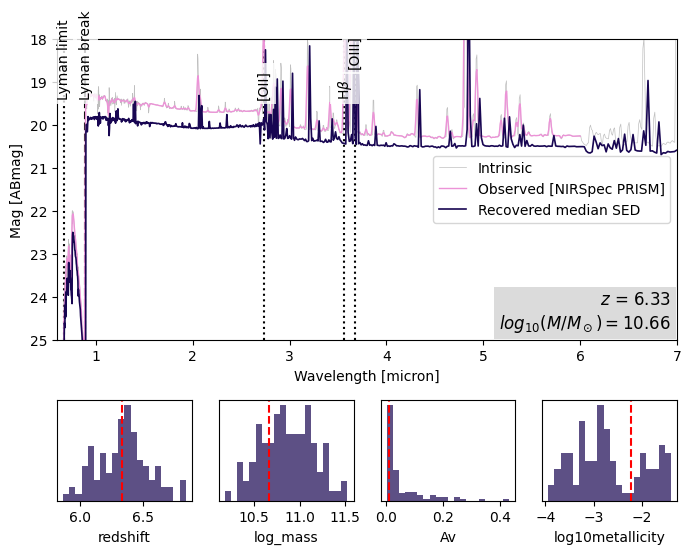

In [280]:
fig = plt.figure(figsize=(8, 6))
# Add GRIDSPEC - top axis is combined, bottom is 5 seperate axes

gs = fig.add_gridspec(2, 4, height_ratios=[3, 1], hspace=0.3)
main_ax = fig.add_subplot(gs[0, :])


plt.gca().invert_yaxis()

print(f"Redshift: {redshift:.2f}, log10(M/Msun): {mass:.2f}")
plt.text(
    0.99,
    0.02,
    f"$z$ = {redshift:.2f}\n$log_{{10}}(M/M_\\odot) = {mass:.2f}$",
    transform=main_ax.transAxes,    fontsize=12,
    color="black",
    horizontalalignment="right",
    verticalalignment="bottom",
    bbox=dict(facecolor="lightgrey", alpha=0.8, edgecolor="none"),
)
# Show Lyman break
plt.axvline(0.1216 * (1 + redshift), color='k', linestyle='--',)# label='Lyman break')
plt.text(0.122 * (1 + redshift), 0.80, 'Lyman break', rotation=90, verticalalignment='bottom', 
                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.axvline(0.0912 * (1 + redshift), color='k', linestyle=':') 
plt.text(0.092 * (1 + redshift), 0.80, 'Lyman limit', rotation=90, verticalalignment='bottom', 
                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show Hb, Ha
plt.axvline(0.4861 * (1 + redshift), color='k', linestyle=':')
plt.text(0.487 * (1 + redshift), 0.80, r'H$\beta$', rotation=90, verticalalignment='bottom', 
                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
#plt.axvline(0.6563 * (1 + redshift), color='k', linestyle=':')
#plt.text(0.657 * (1 + redshift), 0.80, r'H$\alpha$', rotation=90, verticalalignment='bottom', 
#                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
#                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show OIII, OII
plt.axvline(0.5007 * (1 + redshift), color='k', linestyle=':')
plt.text(0.501 * (1 + redshift), 0.90, '[OIII]', rotation=90, verticalalignment='bottom', 
                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.axvline(0.3727 * (1 + redshift), color='k', linestyle=':')
plt.text(0.373 * (1 + redshift), 0.80, '[OII]', rotation=90, verticalalignment='bottom', 
                        transform=main_ax.get_xaxis_transform(), horizontalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# normal_spec
ax = plt.gca()
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())
orig = -2.5 * np.log10(run_model.raw_observation_grid[:, idx]) + 31.4
plt.plot(
    run_model.raw_observation_names * (1 + redshift),
    orig,
    color="gray",
    alpha=0.5,
    linewidth=0.5,
    label="Intrinsic",
)
plt.xlabel("Wavelength [micron]")
plt.ylabel("Mag [ABmag]")
plt.legend()

plt.xlim(0.6, 7)
#plt.xscale("log")
plt.ylim(25, 18)

plt.plot(
    wavs,
    -2.5 * np.log10(10 ** run_model.feature_array[idx]) + 31.4,
    label="Observed [NIRSpec PRISM]",
    lw=1,
    color="#EC93D7"
)
'''
plt.fill_between(wavs.to('um').value, 
          -2.5*np.log10((1+redshift)*transformed_16) + 31.4, 
          -2.5*np.log10((1+redshift)*transformed_84) + 31.4,
          color="#180652", alpha=0.3, label='68% credible interval')
'''
plt.plot(
    sample_wav.to("um").value,
    -2.5 * np.log10( recovered_50) + 31.4,
    label="Recovered median SED",
    lw=1.2,
    color="#180652",
)


plot_params = ['redshift', 'log_mass', 'Av', 'log10metallicity']

for i, param in enumerate(plot_params):
    ax = fig.add_subplot(gs[1, i])
    pidx = list(run_model.fitted_parameter_names).index(param)
    ss = samples[:, pidx]

    ax.hist(
        ss,
        bins=20,
        density=True,
        alpha=0.7,
        color="#180652",

    )
    true = run_model.fitted_parameter_array[idx][pidx]

    ax.axvline(
        true,
        color="red",
        linestyle="--",
    )
    ax.set_xlabel(param)
    ax.set_yticks([])


all_true_params = {
    name: run_model.fitted_parameter_array[idx][i]
    for i, name in enumerate(run_model.fitted_parameter_names)
}

recreated_true = run_model.simulator(all_true_params)

recreated_true_fnu = recreated_true["fnu"]
recreated_true_wav = recreated_true["fnu_wav"]
'''
main_ax.plot(
    recreated_true_wav.to("um").value,
    -2.5 * np.log10(recreated_true_fnu) + 31.4,
    color="green",
    label="Recreated true SED",
    lw=1.5,
)
'''
main_ax.legend()